<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/minyak_goreng_merk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f87759db070>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.minyak_goreng_kemasan_bermerk_2.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


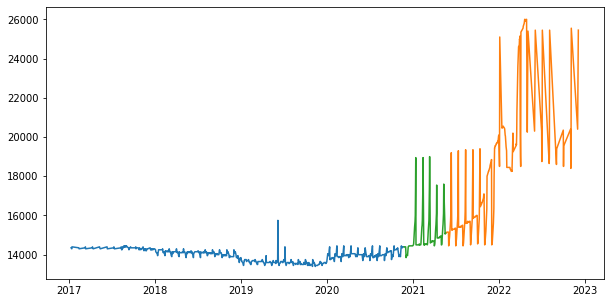

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_minyakgoreng2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 23s 44ms/step - loss: 0.0622 - mae: 0.2378 - mape: 89.1487 - val_loss: 0.0521 - val_mae: 0.1831 - val_mape: 70.7543
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0377 - mae: 0.1792 - mape: 65.1502 - val_loss: 0.0361 - val_mae: 0.1323 - val_mape: 45.6422
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0240 - mae: 0.1357 - mape: 47.4114 - val_loss: 0.0275 - val_mae: 0.1010 - val_mape: 32.2018
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0161 - mae: 0.1055 - mape: 36.1832 - val_loss: 0.0229 - val_mae: 0.0838 - val_mape: 26.6894
Epoch 5/30
44/44 [==============================] - 1s 18ms/step - loss: 0.0116 - mae: 0.0830 - mape: 27.7340 - val_loss: 0.0206 - val_mae: 0.0753 - val_mape: 25.0202
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0090 - mae: 0.0685 - mape: 22.8717 - val_loss: 0.0194 - val_mae: 0.0762 - val_mape: 27.48

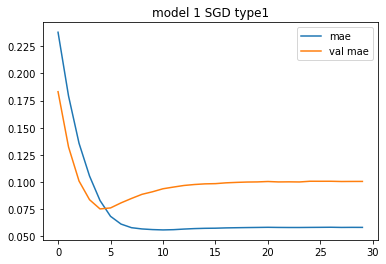

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
2415.87 12.041817 3325.6094178360754


,date,actual,prediction
0,2021-05-20,15100,16373.622070
1,2021-05-21,15100,16376.866211
2,2021-05-24,15150,16380.768555
3,2021-05-25,15150,16387.931641
4,2021-05-27,15150,16393.552734
...,...,...,...
229,2022-11-02,18400,17141.265625
230,2022-11-03,19550,17119.859375
231,2022-11-04,25550,17117.839844
232,2022-12-01,20400,17095.015625


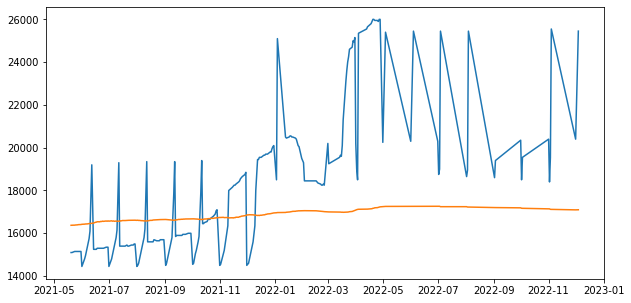

In [ ]:
prediction = forecast_predict(model, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_minyakgoreng2 = pd.DataFrame()
data_new_minyakgoreng2['date'] = y_test
data_new_minyakgoreng2['actual'] = x_test
data_new_minyakgoreng2['prediction'] = data_result
data_new_minyakgoreng2.to_csv('minyakgoreng2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_minyakgoreng2.date, data_new_minyakgoreng2.actual)
plt.plot(data_new_minyakgoreng2.date, data_new_minyakgoreng2.prediction)
data_new_minyakgoreng2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0090 - mae: 0.0727 - mape: 362790.7812 - val_loss: 0.0189 - val_mae: 0.0852 - val_mape: 34.3374
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0085 - mae: 0.0724 - mape: 340879.0000 - val_loss: 0.0189 - val_mae: 0.0882 - val_mape: 36.4789
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0082 - mae: 0.0709 - mape: 393153.0625 - val_loss: 0.0191 - val_mae: 0.0846 - val_mape: 33.7224
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0079 - mae: 0.0681 - mape: 328510.3750 - val_loss: 0.0190 - val_mae: 0.0863 - val_mape: 34.9734
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0076 - mae: 0.0675 - mape: 327874.1250 - val_loss: 0.0191 - val_mae: 0.0876 - val_mape: 35.8953
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0076 - mae: 0.0667 - mape: 366455.2500 - val_loss: 0.0191 - val_

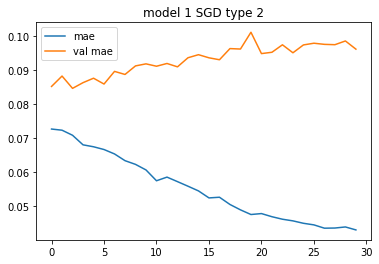

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1721.8096 8.297459 2683.7594899692485


,date,actual,prediction
0,2021-05-20,15100,16373.622070
1,2021-05-21,15100,16376.866211
2,2021-05-24,15150,16380.768555
3,2021-05-25,15150,16387.931641
4,2021-05-27,15150,16393.552734
...,...,...,...
229,2022-11-02,18400,17141.265625
230,2022-11-03,19550,17119.859375
231,2022-11-04,25550,17117.839844
232,2022-12-01,20400,17095.015625


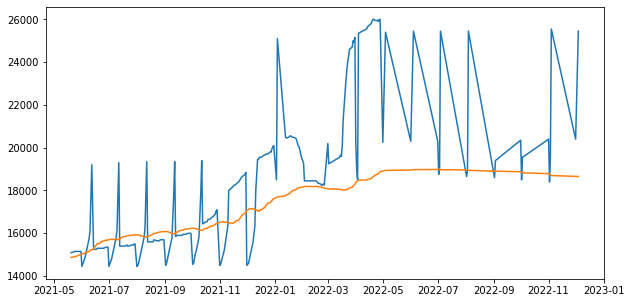

In [ ]:
win_size1 = 60
test_minyakgoreng2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_minyakgoreng2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_minyakgoreng2_1 = pd.DataFrame()
data_new_minyakgoreng2_1['actual'] = x_test
data_new_minyakgoreng2_1['prediction'] = data_result_1
data_new_minyakgoreng2_1.to_csv('minyakgoreng2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng2_1.actual)
plt.plot(y_test, data_new_minyakgoreng2_1.prediction)
data_new_minyakgoreng2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0067 - mae: 0.0560 - mape: 472235.6875 - val_loss: 0.0198 - val_mae: 0.0884 - val_mape: 35.7462
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0065 - mae: 0.0524 - mape: 463757.7188 - val_loss: 0.0199 - val_mae: 0.0867 - val_mape: 34.3485
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0065 - mae: 0.0520 - mape: 454562.2812 - val_loss: 0.0199 - val_mae: 0.0861 - val_mape: 33.8773
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0065 - mae: 0.0512 - mape: 429158.0625 - val_loss: 0.0199 - val_mae: 0.0871 - val_mape: 34.6554
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0065 - mae: 0.0509 - mape: 432276.4062 - val_loss: 0.0199 - val_mae: 0.0872 - val_mape: 34.7749
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0064 - mae: 0.0517 - mape: 459496.3750 - val_loss: 0.0199 - val_mae: 0

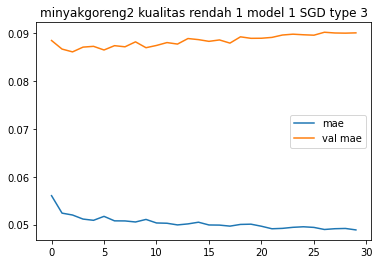

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1676.3694 8.016543 2657.085809679469


,actual,prediction
0,15100,14467.370117
1,15100,14475.357422
2,15150,14491.904297
3,15150,14510.964844
4,15150,14534.325195
...,...,...
229,18400,18903.896484
230,19550,18871.894531
231,25550,18836.589844
232,20400,18798.091797


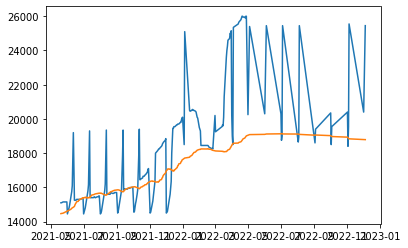

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_minyakgoreng2_2 = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_2['actual'] = x_test
data_new_minyakgoreng2_2['prediction'] = data_result_2
data_new_minyakgoreng2_2.to_csv('minyakgoreng2_model1_sgd_type3')

plt.plot(y_test, data_new_minyakgoreng2_2.actual)
plt.plot(y_test, data_new_minyakgoreng2_2.prediction)
data_new_minyakgoreng2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.0683 - mae: 0.2508 - mape: 94.6561 - val_loss: 0.0581 - val_mae: 0.1988 - val_mape: 78.4917
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0410 - mae: 0.1888 - mape: 69.5088 - val_loss: 0.0330 - val_mae: 0.1197 - val_mape: 39.4872
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0113 - mae: 0.0828 - mape: 28.9840 - val_loss: 0.0203 - val_mae: 0.1106 - val_mape: 51.3739
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0056 - mae: 0.0598 - mape: 24.0685 - val_loss: 0.0198 - val_mae: 0.1051 - val_mape: 47.8170
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0052 - mae: 0.0554 - mape: 21.7954 - val_loss: 0.0201 - val_mae: 0.1083 - val_mape: 49.8830
Epoch 6/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0054 - mae: 0.0573 - mape: 22.8416 - val_loss: 0.0201 - val_mae: 0.1083 - val_mape: 49.844

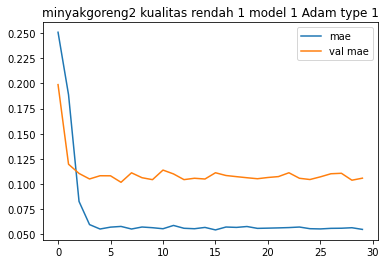

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
1783.4062 8.892598 2575.6893252098553


,actual,prediction
0,15100,15730.790039
1,15100,15736.291992
2,15150,15742.708984
3,15150,15752.398438
4,15150,15761.710938
...,...,...
229,18400,19530.044922
230,19550,19583.134766
231,25550,19465.992188
232,20400,19512.810547


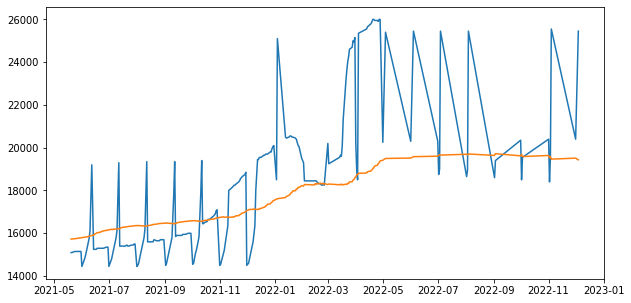

In [ ]:
prediction_a = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_minyakgoreng2_a = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_a['actual'] = x_test
data_new_minyakgoreng2_a['prediction'] = data_result_a
data_new_minyakgoreng2_a.to_csv('minyakgoreng2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_minyakgoreng2_a.actual)
plt.plot(y_test, data_new_minyakgoreng2_a.prediction)
data_new_minyakgoreng2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0053 - mae: 0.0497 - mape: 330904.4375 - val_loss: 0.0200 - val_mae: 0.1024 - val_mape: 45.6540
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0046 - mae: 0.0439 - mape: 190028.9062 - val_loss: 0.0197 - val_mae: 0.0904 - val_mape: 37.4407
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0045 - mae: 0.0417 - mape: 242139.9844 - val_loss: 0.0203 - val_mae: 0.1021 - val_mape: 45.2445
Epoch 4/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0045 - mae: 0.0414 - mape: 192577.8281 - val_loss: 0.0202 - val_mae: 0.1004 - val_mape: 44.0584
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0044 - mae: 0.0409 - mape: 194350.9062 - val_loss: 0.0203 - val_mae: 0.1011 - val_mape: 44.5206
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0044 - mae: 0.0422 - mape: 224794.9219 - val_loss: 0.0202 - val_

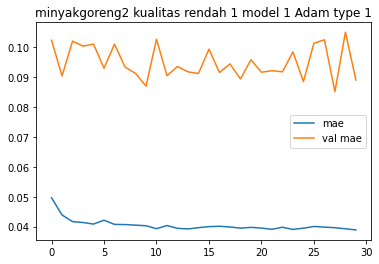

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1473.1874 7.44739 2041.829877830178


,actual,prediction
0,15100,14464.047852
1,15100,14465.094727
2,15150,14504.041992
3,15150,14517.643555
4,15150,14568.057617
...,...,...
229,18400,21921.662109
230,19550,21602.054688
231,25550,21597.517578
232,20400,21311.203125


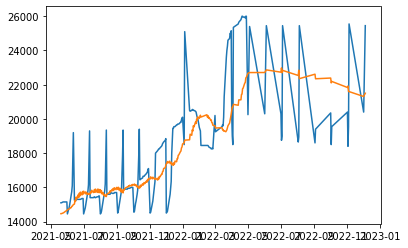

In [ ]:
prediction_a1 = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_minyakgoreng2_a1 = pd.DataFrame()
data_new_minyakgoreng2_a1['actual'] = x_test
data_new_minyakgoreng2_a1['prediction'] = data_result_a1
data_new_minyakgoreng2_a1.to_csv('minyakgoreng2_model1_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng2_a1.actual)
plt.plot(y_test, data_new_minyakgoreng2_a1.prediction)
data_new_minyakgoreng2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0057 - mae: 0.0443 - mape: 351406.8750 - val_loss: 0.0210 - val_mae: 0.0901 - val_mape: 36.4154
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0440 - mape: 351558.5312 - val_loss: 0.0211 - val_mae: 0.0884 - val_mape: 35.0669
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0436 - mape: 324694.5312 - val_loss: 0.0211 - val_mae: 0.0900 - val_mape: 36.3554
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0445 - mape: 349781.3125 - val_loss: 0.0212 - val_mae: 0.0880 - val_mape: 34.7072
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0438 - mape: 339806.1562 - val_loss: 0.0213 - val_mae: 0.0872 - val_mape: 34.0027
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0057 - mae: 0.0427 - mape: 337195.6250 - val_loss: 0.0211 - val_mae: 0

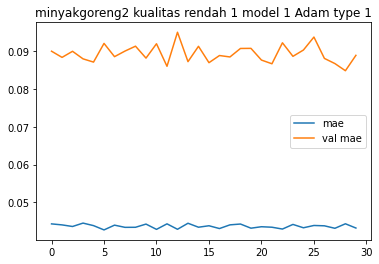

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1467.2712 7.4318485 2033.5020899915496


,actual,prediction
0,15100,14448.929688
1,15100,14448.723633
2,15150,14489.528320
3,15150,14502.653320
4,15150,14554.837891
...,...,...
229,18400,22190.796875
230,19550,21880.800781
231,25550,21905.755859
232,20400,21618.460938


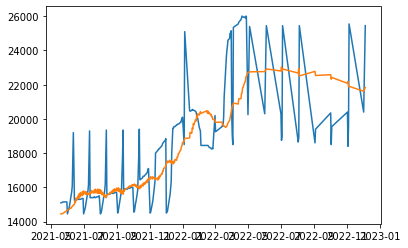

In [ ]:
prediction_a2 = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_minyakgoreng2_a2 = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_a2['actual'] = x_test
data_new_minyakgoreng2_a2['prediction'] = data_result_a2
data_new_minyakgoreng2_a2.to_csv('minyakgoreng2_model1_adam_type3.csv')

plt.plot(y_test, data_new_minyakgoreng2_a2.actual)
plt.plot(y_test, data_new_minyakgoreng2_a2.prediction)
data_new_minyakgoreng2_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 41ms/step - loss: 0.0409 - mae: 0.1831 - mape: 68.5554 - val_loss: 0.0191 - val_mae: 0.0878 - val_mape: 36.1539
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0062 - mae: 0.0612 - mape: 24.1080 - val_loss: 0.0209 - val_mae: 0.1134 - val_mape: 53.2547
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0054 - mae: 0.0551 - mape: 21.6804 - val_loss: 0.0210 - val_mae: 0.1140 - val_mape: 53.6377
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0054 - mae: 0.0552 - mape: 21.6184 - val_loss: 0.0203 - val_mae: 0.1081 - val_mape: 49.7908
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0052 - mae: 0.0552 - mape: 21.7113 - val_loss: 0.0207 - val_mae: 0.1114 - val_mape: 51.9459
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0055 - mae: 0.0562 - mape: 21.9989 - val_loss: 0.0196 - val_mae: 0.1005 - val_mape: 44.929

17/17 [==============================] - 0s 7ms/step - loss: 0.0952 - mae: 0.2353 - mape: 33.0694


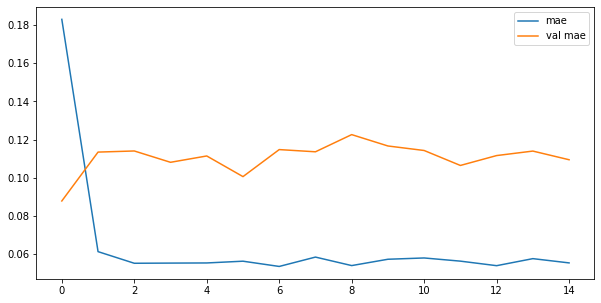

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_minyakgoreng21 = pd.DataFrame()
data_new_minyakgoreng21['actual'] = x_test
data_new_minyakgoreng21['prediction'] = data_result1
data_new_minyakgoreng21.to_csv('minyakgoreng2_model2_adam_type1.csv')

data_new_minyakgoreng21

131/131 [==============================] - 2s 7ms/step
1767.2986 8.847547 2529.1149637768544


,actual,prediction
0,15100,15724.801758
1,15100,15725.174805
2,15150,15732.257812
3,15150,15735.593750
4,15150,15746.585938
...,...,...
229,18400,19927.230469
230,19550,19778.546875
231,25550,19827.658203
232,20400,19680.113281


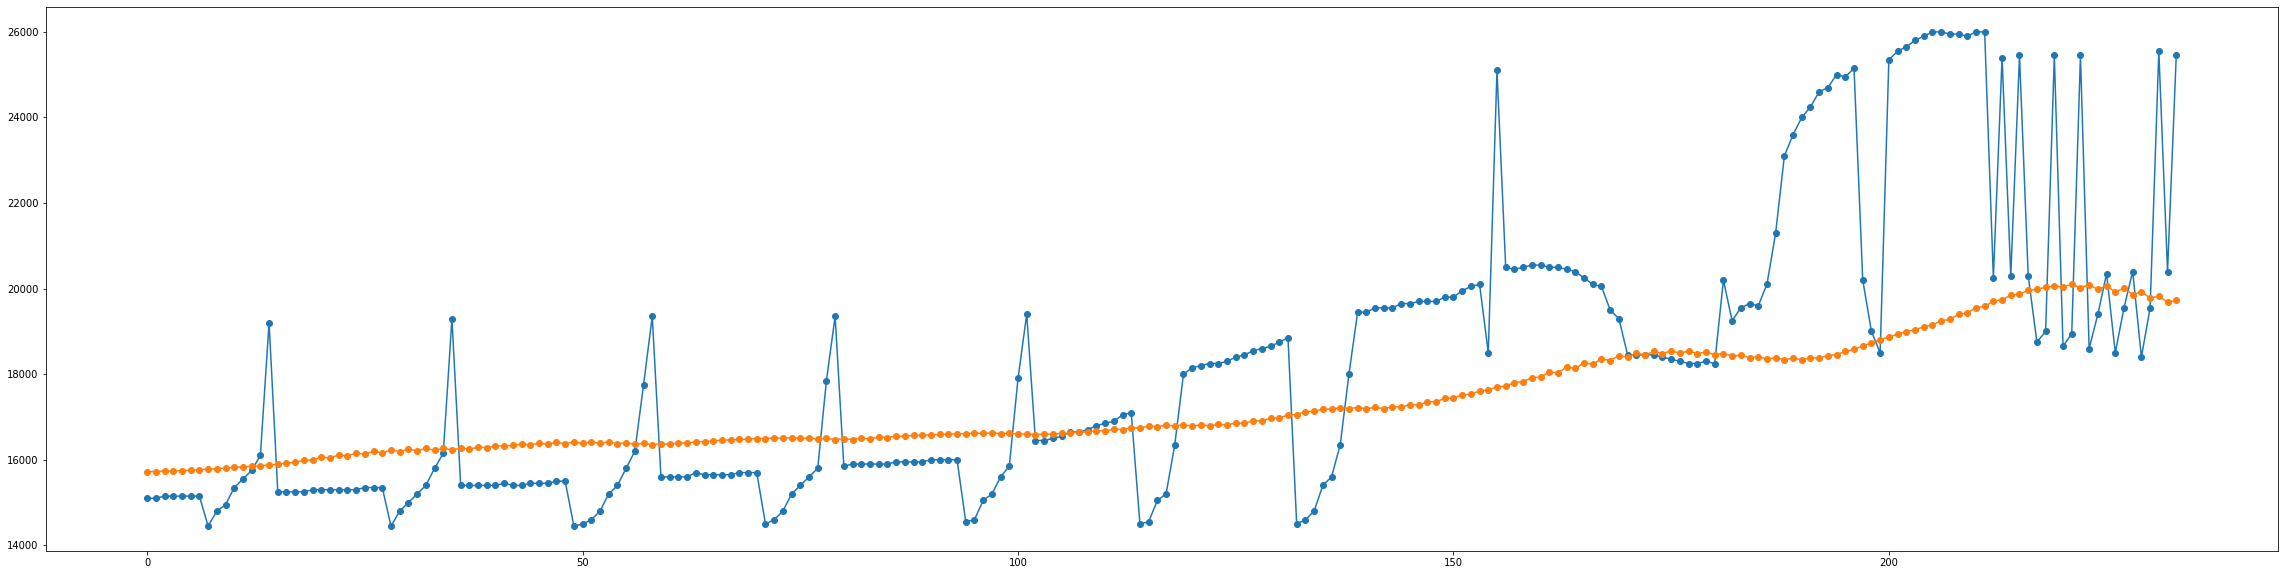

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_minyakgoreng21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_minyakgoreng21['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 23s 10ms/step - loss: 0.0107 - mae: 0.0704 - mape: 273166.7812 - val_loss: 0.0208 - val_mae: 0.1105 - val_mape: 51.2529
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0048 - mae: 0.0450 - mape: 157154.8594 - val_loss: 0.0209 - val_mae: 0.1097 - val_mape: 50.8144
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0045 - mae: 0.0422 - mape: 181588.2344 - val_loss: 0.0213 - val_mae: 0.1110 - val_mape: 51.6495
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0045 - mae: 0.0418 - mape: 222683.5938 - val_loss: 0.0201 - val_mae: 0.0924 - val_mape: 39.3677
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0044 - mae: 0.0419 - mape: 210172.3438 - val_loss: 0.0200 - val_mae: 0.0890 - val_mape: 37.0695
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0044 - mae: 0.0404 - mape: 214726.4375 - val_loss: 0.0206 - va

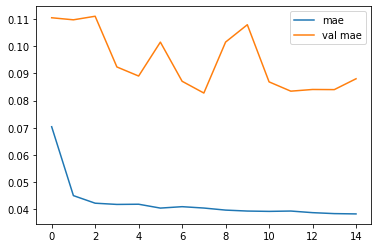

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 5ms/step
1645.9105 8.316522 2392.44456571098


,actual,prediction
0,15100,14466.350586
1,15100,14481.015625
2,15150,14513.598633
3,15150,14543.901367
4,15150,14602.138672
...,...,...
229,18400,22492.531250
230,19550,20719.269531
231,25550,21655.583984
232,20400,19656.636719


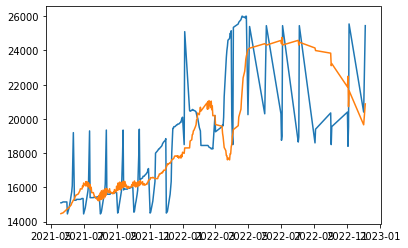

In [14]:
prediction1_1 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_minyakgoreng21_1 = pd.DataFrame()
data_new_minyakgoreng21_1['actual'] = x_test
data_new_minyakgoreng21_1['prediction'] = data_result1_1
data_new_minyakgoreng21_1.to_csv('minyakgoreng2_model2_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng21_1.actual)
plt.plot(y_test, data_new_minyakgoreng21_1.prediction)
data_new_minyakgoreng21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0050 - mae: 0.0402 - mape: 305690.4375 - val_loss: 0.0181 - val_mae: 0.0839 - val_mape: 35.2769
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0050 - mae: 0.0404 - mape: 299981.6250 - val_loss: 0.0183 - val_mae: 0.0838 - val_mape: 34.5156
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0050 - mae: 0.0401 - mape: 297509.3125 - val_loss: 0.0184 - val_mae: 0.0839 - val_mape: 34.4102
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0049 - mae: 0.0401 - mape: 295791.4688 - val_loss: 0.0181 - val_mae: 0.0845 - val_mape: 35.5041
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0049 - mae: 0.0397 - mape: 261042.5000 - val_loss: 0.0180 - val_mae: 0.0830 - val_mape: 33.9793
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0049 - mae: 0.0394 - mape: 285661.2500 - val_loss: 0.0182 - val_mae: 0

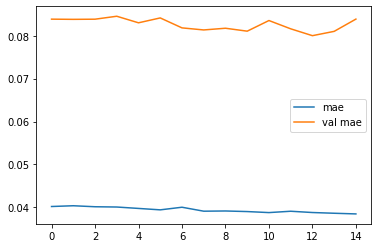

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1772.4043 9.060753 2611.5894585481847


,actual,prediction
0,15100,14489.057617
1,15100,14461.166992
2,15150,14469.857422
3,15150,14455.687500
4,15150,14500.897461
...,...,...
229,18400,25218.199219
230,19550,23789.548828
231,25550,24268.402344
232,20400,22711.146484


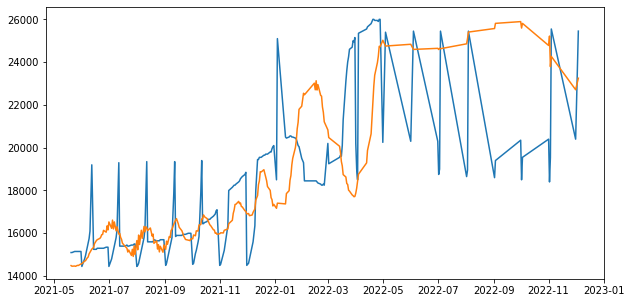

In [ ]:
prediction1_2 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_minyakgoreng21_2 = pd.DataFrame()
data_new_minyakgoreng21_2['actual'] = x_test
data_new_minyakgoreng21_2['prediction'] = data_result1_2
data_new_minyakgoreng21_2.to_csv('minyakgoreng2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_2.actual)
plt.plot(y_test, data_new_minyakgoreng21_2.prediction)

data_new_minyakgoreng21_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0623 - mae: 0.2379 - mape: 89.1385 - val_loss: 0.0544 - val_mae: 0.1890 - val_mape: 73.6105
Epoch 2/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0416 - mae: 0.1897 - mape: 69.4646 - val_loss: 0.0399 - val_mae: 0.1456 - val_mape: 52.1756
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0283 - mae: 0.1509 - mape: 53.5316 - val_loss: 0.0309 - val_mae: 0.1124 - val_mape: 36.3944
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0196 - mae: 0.1199 - mape: 41.4664 - val_loss: 0.0252 - val_mae: 0.0919 - val_mape: 28.9300
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0140 - mae: 0.0962 - mape: 32.6604 - val_loss: 0.0221 - val_mae: 0.0807 - val_mape: 25.9286
Epoch 6/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0108 - mae: 0.0781 - mape: 26.0535 - val_loss: 0.0203 - val_mae: 0.0752 - val_mape: 25.486

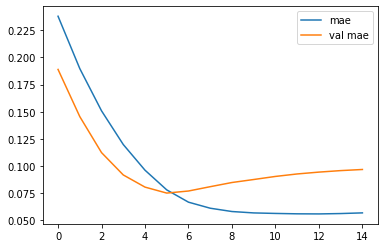

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2437.1216 12.116629 3361.6631300592867


,actual,prediction
0,15100,16373.139648
1,15100,16375.891602
2,15150,16377.651367
3,15150,16381.804688
4,15150,16385.794922
...,...,...
229,18400,17070.300781
230,19550,17056.226562
231,25550,17040.607422
232,20400,17030.001953


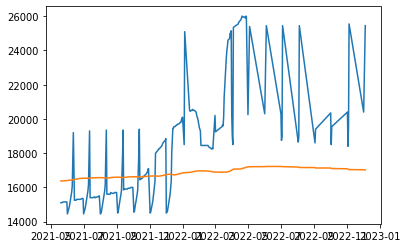

In [ ]:
prediction1_a = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_minyakgoreng21_a = pd.DataFrame()
data_new_minyakgoreng21_a['actual'] = x_test
data_new_minyakgoreng21_a['prediction'] = data_result1_a
data_new_minyakgoreng21_a.to_csv('minyakgoreng2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_minyakgoreng21_a.actual)
plt.plot(y_test, data_new_minyakgoreng21_a.prediction)

data_new_minyakgoreng21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0096 - mae: 0.0778 - mape: 431270.3750 - val_loss: 0.0190 - val_mae: 0.0817 - val_mape: 31.7333
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0085 - mae: 0.0731 - mape: 379054.3125 - val_loss: 0.0189 - val_mae: 0.0863 - val_mape: 35.2190
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0077 - mae: 0.0686 - mape: 331122.1250 - val_loss: 0.0190 - val_mae: 0.0885 - val_mape: 36.7491
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0070 - mae: 0.0636 - mape: 328329.2188 - val_loss: 0.0191 - val_mae: 0.0938 - val_mape: 40.4377
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0068 - mae: 0.0613 - mape: 323900.9375 - val_loss: 0.0190 - val_mae: 0.0899 - val_mape: 37.7781
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0065 - mae: 0.0598 - mape: 346347.2500 - val_loss: 0.0192 - val_

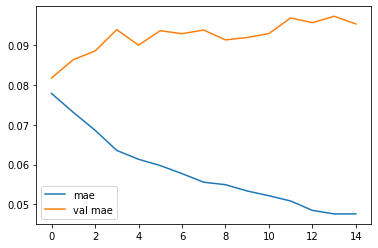

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1898.278 9.136696 2904.2616961975036


,actual,prediction
0,15100,15085.112305
1,15100,15091.084961
2,15150,15098.959961
3,15150,15109.376953
4,15150,15122.745117
...,...,...
229,18400,18119.029297
230,19550,18076.589844
231,25550,18057.271484
232,20400,18017.884766


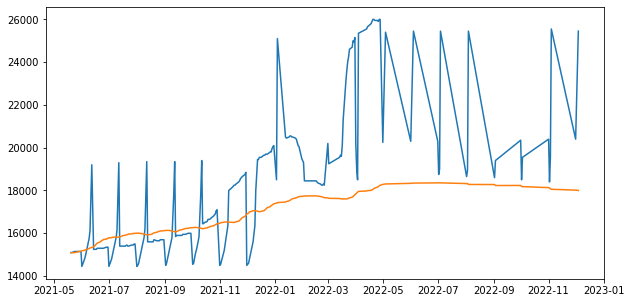

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_minyakgoreng21_a1 = pd.DataFrame()
data_new_minyakgoreng21_a1['actual'] = x_test
data_new_minyakgoreng21_a1['prediction'] = data_result1_a1
data_new_minyakgoreng21_a1.to_csv('minyakgoreng2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_a1.actual)
plt.plot(y_test, data_new_minyakgoreng21_a1.prediction)
data_new_minyakgoreng21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0074 - mae: 0.0619 - mape: 612695.0625 - val_loss: 0.0197 - val_mae: 0.0853 - val_mape: 33.8391
Epoch 2/15
84/84 [==============================] - 2s 17ms/step - loss: 0.0070 - mae: 0.0576 - mape: 534241.4375 - val_loss: 0.0197 - val_mae: 0.0841 - val_mape: 32.8709
Epoch 3/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0070 - mae: 0.0564 - mape: 512965.2500 - val_loss: 0.0197 - val_mae: 0.0842 - val_mape: 32.9619
Epoch 4/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0070 - mae: 0.0563 - mape: 512181.8125 - val_loss: 0.0198 - val_mae: 0.0837 - val_mape: 32.5256
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0069 - mae: 0.0555 - mape: 502190.5000 - val_loss: 0.0198 - val_mae: 0.0840 - val_mape: 32.7832
Epoch 6/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0069 - mae: 0.0558 - mape: 501812.5312 - val_loss: 0.0198 - val_mae: 0

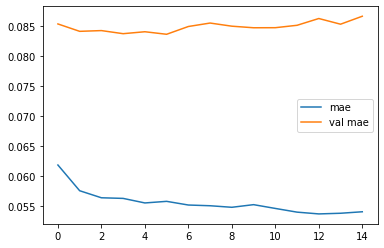

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
1879.384 8.942168 2932.426981188108


,actual,prediction
0,15100,14672.239258
1,15100,14677.783203
2,15150,14685.691406
3,15150,14695.730469
4,15150,14709.243164
...,...,...
229,18400,18122.552734
230,19550,18074.150391
231,25550,18054.275391
232,20400,18009.636719


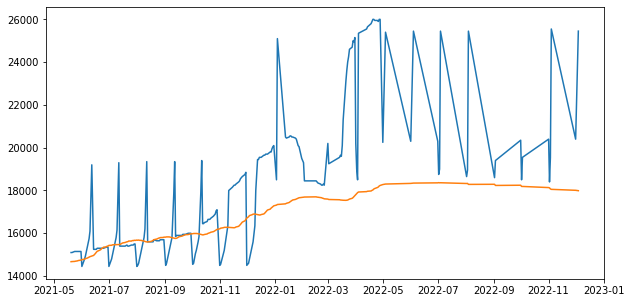

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_minyakgoreng21_a2 = pd.DataFrame()
data_new_minyakgoreng21_a2['actual'] = x_test
data_new_minyakgoreng21_a2['prediction'] = data_result1_a2
data_new_minyakgoreng21_a2.to_csv('minyakgoreng2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_a2.actual)
plt.plot(y_test, data_new_minyakgoreng21_a2.prediction)

data_new_minyakgoreng21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 32ms/step - loss: 0.0682 - mae: 0.2499 - mape: 93.9089 - val_loss: 0.0605 - val_mae: 0.2051 - val_mape: 81.6801
Epoch 2/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0505 - mae: 0.2118 - mape: 78.3543 - val_loss: 0.0468 - val_mae: 0.1684 - val_mape: 63.5493
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0373 - mae: 0.1780 - mape: 64.5113 - val_loss: 0.0374 - val_mae: 0.1375 - val_mape: 48.3201
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0280 - mae: 0.1491 - mape: 52.6467 - val_loss: 0.0308 - val_mae: 0.1124 - val_mape: 36.4672
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0213 - mae: 0.1267 - mape: 44.1066 - val_loss: 0.0265 - val_mae: 0.0974 - val_mape: 30.9393
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0167 - mae: 0.1078 - mape: 36.9129 - val_loss: 0.0234 - val_mae: 0.0856 - val_mape: 27.035

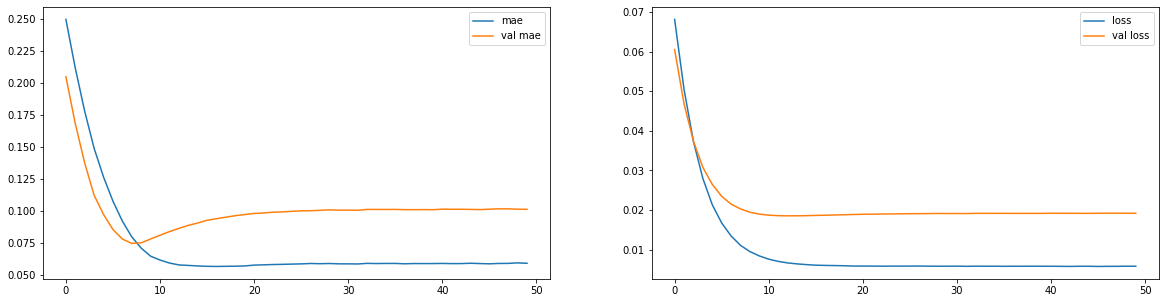

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
2537.0352 12.678253 3454.7338537143496


,actual,prediction
0,15100,16601.087891
1,15100,16602.103516
2,15150,16602.355469
3,15150,16603.923828
4,15150,16604.941406
...,...,...
229,18400,16868.273438
230,19550,16880.980469
231,25550,16870.599609
232,20400,16878.646484


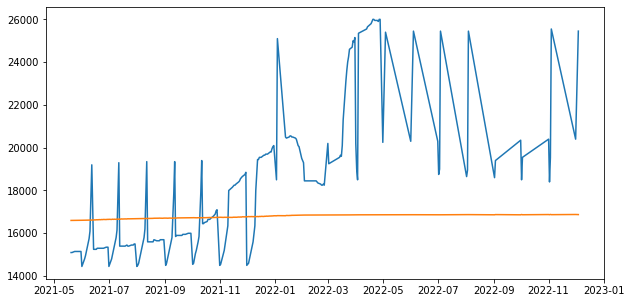

In [ ]:
prediction2 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_minyakgoreng22 = pd.DataFrame()
data_new_minyakgoreng22['actual'] = x_test
data_new_minyakgoreng22['prediction'] = data_result2
data_new_minyakgoreng22.to_csv('minyakgoreng2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng22.actual)
plt.plot(y_test, data_new_minyakgoreng22.prediction)
data_new_minyakgoreng22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0114 - mae: 0.0857 - mape: 518449.0312 - val_loss: 0.0188 - val_mae: 0.0799 - val_mape: 30.6371
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0111 - mae: 0.0873 - mape: 486137.4062 - val_loss: 0.0189 - val_mae: 0.0796 - val_mape: 30.3217
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0110 - mae: 0.0869 - mape: 488279.8438 - val_loss: 0.0190 - val_mae: 0.0786 - val_mape: 29.5372
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0109 - mae: 0.0860 - mape: 460481.2812 - val_loss: 0.0189 - val_mae: 0.0794 - val_mape: 30.2095
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0108 - mae: 0.0850 - mape: 449713.2812 - val_loss: 0.0189 - val_mae: 0.0795 - val_mape: 30.2863
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0107 - mae: 0.0853 - mape: 461731.3438 - val_loss: 0.0189 - val_

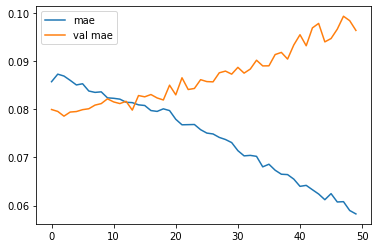

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_minyakgoreng22_1 = pd.DataFrame()
data_new_minyakgoreng22_1['actual'] = x_test
data_new_minyakgoreng22_1['prediction'] = data_result2_1
data_new_minyakgoreng22_1.to_csv('minyakgoreng2_model3_sgd_type2.csv')

data_new_minyakgoreng22

199/199 [==============================] - 1s 3ms/step
2105.055 10.087057 3169.773020265016


,actual,prediction
0,15100,16601.087891
1,15100,16602.103516
2,15150,16602.355469
3,15150,16603.923828
4,15150,16604.941406
...,...,...
229,18400,16868.273438
230,19550,16880.980469
231,25550,16870.599609
232,20400,16878.646484


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0097 - mae: 0.0764 - mape: 719382.0625 - val_loss: 0.0190 - val_mae: 0.0878 - val_mape: 36.0797
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0092 - mae: 0.0728 - mape: 646467.0000 - val_loss: 0.0191 - val_mae: 0.0839 - val_mape: 33.1635
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0090 - mae: 0.0719 - mape: 637044.5000 - val_loss: 0.0192 - val_mae: 0.0825 - val_mape: 32.0523
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0089 - mae: 0.0709 - mape: 608834.1875 - val_loss: 0.0192 - val_mae: 0.0820 - val_mape: 31.6227
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0089 - mae: 0.0706 - mape: 613804.4375 - val_loss: 0.0192 - val_mae: 0.0820 - val_mape: 31.6452
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0089 - mae: 0.0706 - mape: 608132.8125 - val_loss: 0.0192 - val_mae: 0

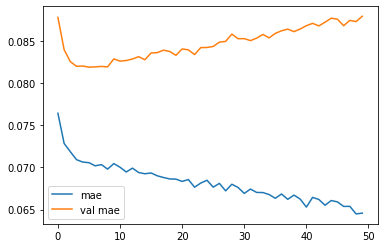

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_minyakgoreng22_2 = pd.DataFrame()
data_new_minyakgoreng22_2['actual'] = x_test
data_new_minyakgoreng22_2['prediction'] = data_result2_2
data_new_minyakgoreng22_2.to_csv('minyakgoreng2_model3_sgd-type3.csv')

data_new_minyakgoreng22_2

181/181 [==============================] - 1s 4ms/step
2045.2194 9.71289 3138.7537335700613


,actual,prediction
0,15100,14748.501953
1,15100,14749.506836
2,15150,14750.592773
3,15150,14751.706055
4,15150,14754.885742
...,...,...
229,18400,17735.583984
230,19550,17701.759766
231,25550,17720.523438
232,20400,17712.203125


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.0568 - mae: 0.2260 - mape: 84.5082 - val_loss: 0.0393 - val_mae: 0.1439 - val_mape: 51.3787
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0132 - mae: 0.0936 - mape: 35.3663 - val_loss: 0.0207 - val_mae: 0.1138 - val_mape: 53.3602
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0054 - mae: 0.0543 - mape: 21.1756 - val_loss: 0.0196 - val_mae: 0.1039 - val_mape: 46.9539
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0053 - mae: 0.0559 - mape: 22.3057 - val_loss: 0.0193 - val_mae: 0.1005 - val_mape: 44.7525
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0052 - mae: 0.0529 - mape: 20.7274 - val_loss: 0.0197 - val_mae: 0.1057 - val_mape: 48.1500
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0054 - mae: 0.0551 - mape: 21.8926 - val_loss: 0.0205 - val_mae: 0.1124 - val_mape: 52.505

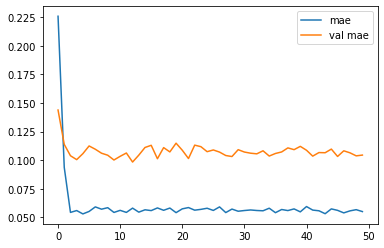

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_minyakgoreng22_a = pd.DataFrame()
data_new_minyakgoreng22_a['actual'] = x_test
data_new_minyakgoreng22_a['prediction'] = data_result2_a
data_new_minyakgoreng22_a.to_csv('minyakgoreng2_model3_adam-type1.csv')

data_new_minyakgoreng22_a

131/131 [==============================] - 1s 6ms/step
1875.6608 9.3369255 2691.513050312036


,actual,prediction
0,15100,15886.506836
1,15100,15888.701172
2,15150,15895.470703
3,15150,15904.710938
4,15150,15903.467773
...,...,...
229,18400,19489.490234
230,19550,19497.535156
231,25550,19658.273438
232,20400,19479.078125


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0059 - mae: 0.0544 - mape: 223192.4844 - val_loss: 0.0203 - val_mae: 0.1074 - val_mape: 49.0657
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0053 - mae: 0.0490 - mape: 348255.1875 - val_loss: 0.0210 - val_mae: 0.1117 - val_mape: 51.7800
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0048 - mae: 0.0450 - mape: 146021.7656 - val_loss: 0.0201 - val_mae: 0.0966 - val_mape: 41.9783
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0047 - mae: 0.0432 - mape: 175699.1094 - val_loss: 0.0226 - val_mae: 0.1203 - val_mape: 57.2841
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0047 - mae: 0.0435 - mape: 325063.7188 - val_loss: 0.0216 - val_mae: 0.1126 - val_mape: 52.2982
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0047 - mae: 0.0437 - mape: 170647.7969 - val_loss: 0.0207 - val_

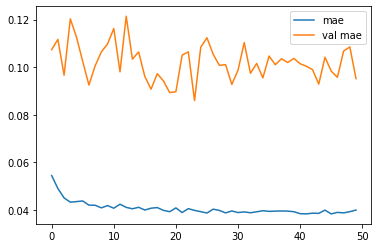

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
1559.7118 7.7075152 2263.154546203153


,actual,prediction
0,15100,14252.091797
1,15100,14250.701172
2,15150,14293.887695
3,15150,14295.535156
4,15150,14317.988281
...,...,...
229,18400,20868.167969
230,19550,20767.794922
231,25550,21024.394531
232,20400,20574.576172


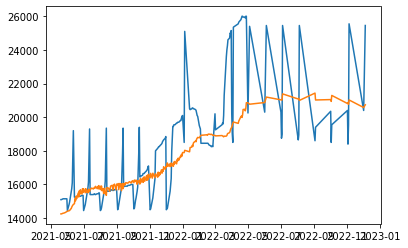

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_minyakgoreng22_a1 = pd.DataFrame()
data_new_minyakgoreng22_a1['actual'] = x_test
data_new_minyakgoreng22_a1['prediction'] = data_result2_a1
data_new_minyakgoreng22_a1.to_csv('minyakgoreng2_model3_adam-type2.csv')

plt.plot(y_test, data_new_minyakgoreng22_a1.actual)
plt.plot(y_test, data_new_minyakgoreng22_a1.prediction)
data_new_minyakgoreng22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0055 - mae: 0.0416 - mape: 309309.7188 - val_loss: 0.0207 - val_mae: 0.0954 - val_mape: 40.8644
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0055 - mae: 0.0431 - mape: 342911.5000 - val_loss: 0.0208 - val_mae: 0.0947 - val_mape: 40.3433
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0055 - mae: 0.0434 - mape: 336603.0625 - val_loss: 0.0208 - val_mae: 0.0954 - val_mape: 40.7879
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0056 - mae: 0.0433 - mape: 308289.5625 - val_loss: 0.0210 - val_mae: 0.1011 - val_mape: 44.5434
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0055 - mae: 0.0434 - mape: 331783.3750 - val_loss: 0.0210 - val_mae: 0.0985 - val_mape: 42.8176
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0055 - mae: 0.0424 - mape: 337036.0938 - val_loss: 0.0210 - val_mae: 0

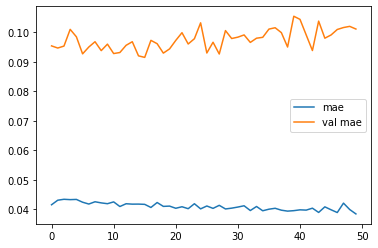

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
1469.0828 7.2597685 2145.6020134218743


,actual,prediction
0,15100,15607.797852
1,15100,15555.935547
2,15150,15586.675781
3,15150,15549.063477
4,15150,15576.019531
...,...,...
229,18400,21299.625000
230,19550,20944.935547
231,25550,20967.582031
232,20400,20894.591797


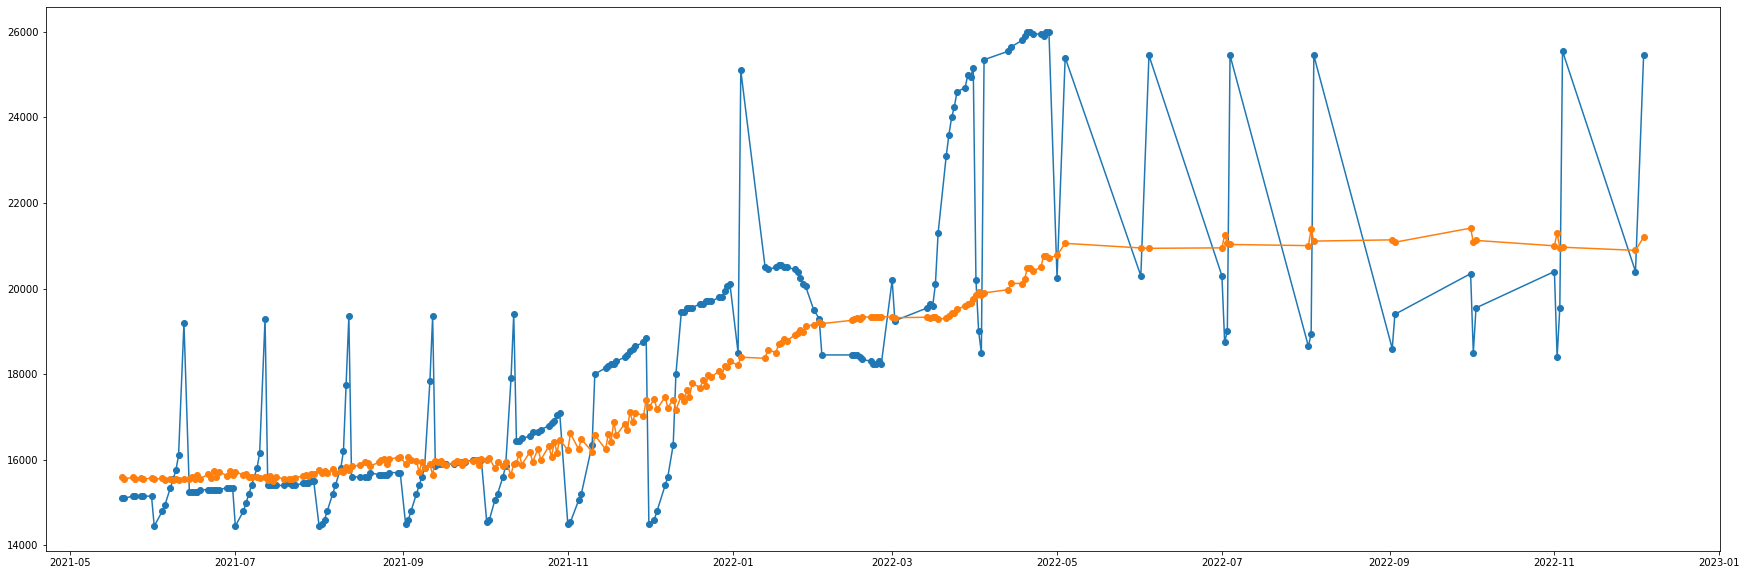

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_minyakgoreng22_a2 = pd.DataFrame()
data_new_minyakgoreng22_a2['actual'] = x_test
data_new_minyakgoreng22_a2['prediction'] = data_result2_a2
data_new_minyakgoreng22_a2.to_csv('minyakgoreng2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_minyakgoreng22_a2.actual, '-o')
plt.plot(y_test,data_new_minyakgoreng22_a2.prediction, '-o')
data_new_minyakgoreng22_a2